In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
from PIL import Image
import cv2

from skimage import io, transform, color
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

/Users/ikwang/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [16]:
# select labels
labels_path = [i.replace('.png', '.jpeg') for i in os.listdir('./labels')]
print(labels_path[0:2])
labels_path = set(labels_path)
                 
# select images without labels
images_path = set(os.listdir('./images'))
imgs_to_be_removed = list(images_path.difference(labels_path))
print()
print(len(imgs_to_be_removed)) # check difference btw both paths

# # remove images without labels from directory
# for image in imgs_to_be_removed:
#     os.remove(f'./images/{image}')
print(len(images_path.difference(labels_path))) # check difference btw both paths

['IMG_5178.jpeg', 'IMG_5144.jpeg']

0
0


In [2]:
current_dir = os.getcwd()
img_name = 'IMG_5019.png'

# Display one example label
image = io.imread('./labels/' + img_name)
print(image.shape)
# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Display the grayscale image
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

(4032, 3024, 3)


### Load Dataset

In [11]:
class RoadDataset(Dataset):
    """ Road Dataset"""

    def __init__(self, sample_files_path, labels_files_path, transform=None):
        """
        Arguments:
            sample_files_path (str): Directory with all images
            labels_files_path (str): Directory with all labels (segmentation mask for the road)
            transform (callable, optional): Optional transform function to be applied

        Output:
            dict: Dictionary of image, corresponding label and dict containing path to image & label.
        """
        self.sample_files_path = sample_files_path
        self.labels_files_path = labels_files_path
        self.transform = transform
        

    def _rotate(self, image):
        """ Helper function to enforce the orientation of original picture
            Returns: Np array of image
        """
        
        if hasattr(image, '_getexif'):  # Check if image has EXIF data
            exif = image._getexif()
            if exif is not None:
                orientation = exif.get(0x0112)
                if orientation == 3:
                    image = image.rotate(180, expand=True)
                elif orientation == 6:
                    image = image.rotate(270, expand=True)
                elif orientation == 8:
                    image = image.rotate(90, expand=True)
        return np.array(image) # return an np array of image
        

    def __len__(self):
        return len(os.listdir(self.sample_files_path))

    def __getitem__(self, idx):

        # get requested file name from sorted list of image files in both paths
        sample_img_name = sorted(os.listdir(self.sample_files_path))[idx]
        label_img_name = sorted(os.listdir(self.labels_files_path))[idx]

        # open files(image and label) and save in memory
        sample_path = os.path.join(sample_files_path, sample_img_name)
        sample = Image.open(sample_path)
        sample = self._rotate(sample) # ensure orientation is kept

        label_path = os.path.join(labels_files_path, label_img_name)
        label = io.imread(label_path)
        label = color.rgb2gray(label) # Convert the label to grayscale
        label = np.expand_dims(label, axis=2) # convert from 2d to 3d 
        

        if self.transform:
            sample = self.transform[0](sample)
            # Skip normalization for label images
            label = self.transform[1](label)
                
        return {"image": sample, "label":label, "file_names":{'image':sample_path, 'label_img_name':label_path}}


    

0 (4032, 3024, 3) (4032, 3024, 1)
1 (4032, 3024, 3) (4032, 3024, 1)
2 (4032, 3024, 3) (4032, 3024, 1)
3 (4032, 3024, 3) (4032, 3024, 1)


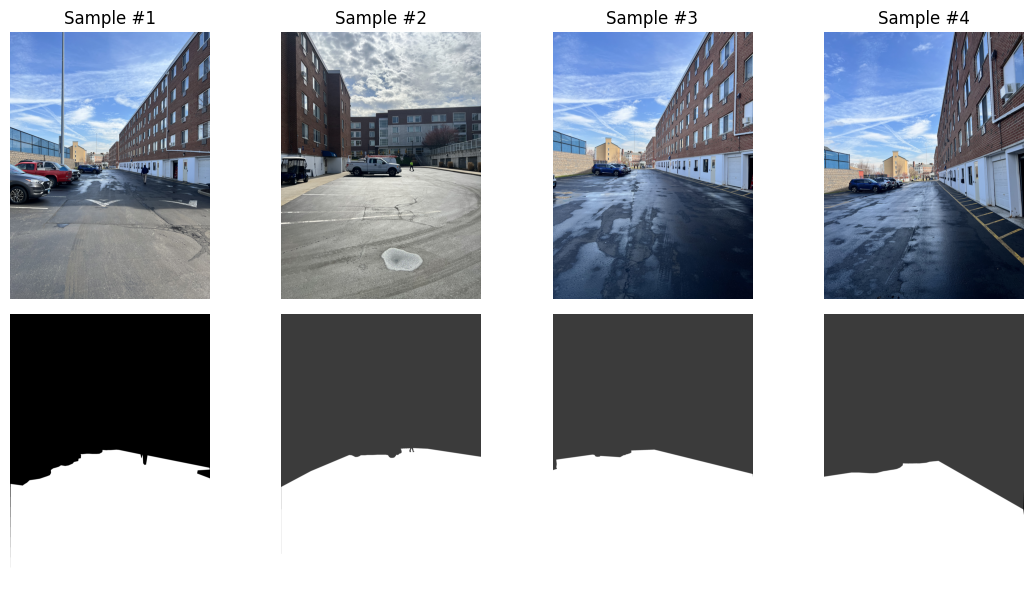

In [5]:
# testing roaddataset class
sample_files_path = './images/'
labels_files_path = './labels/'


# instantiate class
road_ds = RoadDataset(sample_files_path, labels_files_path)

# plot 4 figures
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, example in enumerate(road_ds):
    print(i, example['image'].shape, example['label'].shape)

    # plot figure
    axes[0, i].imshow(example['image'])
    # axes[1, i].imshow(Image.fromarray(example['label']))
    axes[1, i].imshow(example['label'], cmap='gray')
    
    axes[0, i].set_title('Sample #{}'.format(i+1))
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    plt.tight_layout()

    if i == 3:
        plt.show()
        break

In [285]:
# write transforms, the class method is used as opposed to writing just functions

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image = transform.resize(image, (new_h, new_w))

        return image


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = torch.tensor(image.transpose((2, 0, 1)), dtype=torch.float)
        return image

In [35]:
# manually testing transforms without dataloader method
scale = Rescale(256) # instantiate Rescale class
sample_1 = road_ds[1]['image'] #
sample_1_rescaled = scale(sample_1) # transform sample
sample_1_rescaled.shape

(256, 256, 3)

In [279]:
tnsr = ToTensor()
tnsr(road_ds[1]['label']).shape

(4032, 3024, 1)


torch.Size([1, 4032, 3024])

In [62]:
# Plot either the sample image or label showing the original size and the rescaled size

fig = plt.figure()
for ix, sample in enumerate([sample_1, sample_1_rescaled]):
    ax = plt.subplot(1, 2, ix + 1)
    plt.tight_layout()
    if ix == 0:
        ax.set_title('Sample 1')
    else:
        ax.set_title('Sample 1 Rescaled')
    ax.axis('off')
    plt.imshow(sample)

In [12]:
# Build transforms, and create train, validation & test data Splits

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

trfms_img = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(size=(256, 256)),
                transforms.Normalize(mean=mean,
                                     std=std)
            ])
trfms_label = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(size=(256, 256))
            ])

# instantiate dataset
dataset = RoadDataset(sample_files_path, 
                      labels_files_path, 
                      transform=[trfms_img, trfms_label])

print("Random Sample shape:")
print(road_ds[2]['label'].shape)
print()

# split dataset into training and validation sets
train_indices, val_indices = train_test_split(
    np.arange(len(dataset)),
    test_size=0.2,
    random_state=42
)

val_indices, test_indices = train_test_split(
    np.arange(len(val_indices)),
    test_size=0.5,
    random_state=42
)
print(len(train_indices), len(val_indices), len(test_indices))

Random Sample shape:
(4032, 3024, 1)

159 20 20


In [13]:
# create data loaders for training, validation and test sets

train_loader = DataLoader(
    dataset=torch.utils.data.Subset(dataset, train_indices),
    batch_size=8,
    shuffle=True
)

val_loader = DataLoader(
    dataset=torch.utils.data.Subset(dataset, val_indices),
    batch_size=8,
    shuffle=False
)

test_loader = DataLoader(
    dataset=torch.utils.data.Subset(dataset, test_indices),
    batch_size=8,
    shuffle=False
)

In [48]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), sample_batched['label'].size())

    

0 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
1 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
2 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
3 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
4 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
5 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
6 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
7 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
8 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
9 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
10 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
11 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
12 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
13 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
14 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
15 torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
16 torch.Size([8, 3, 256, 256]) to

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


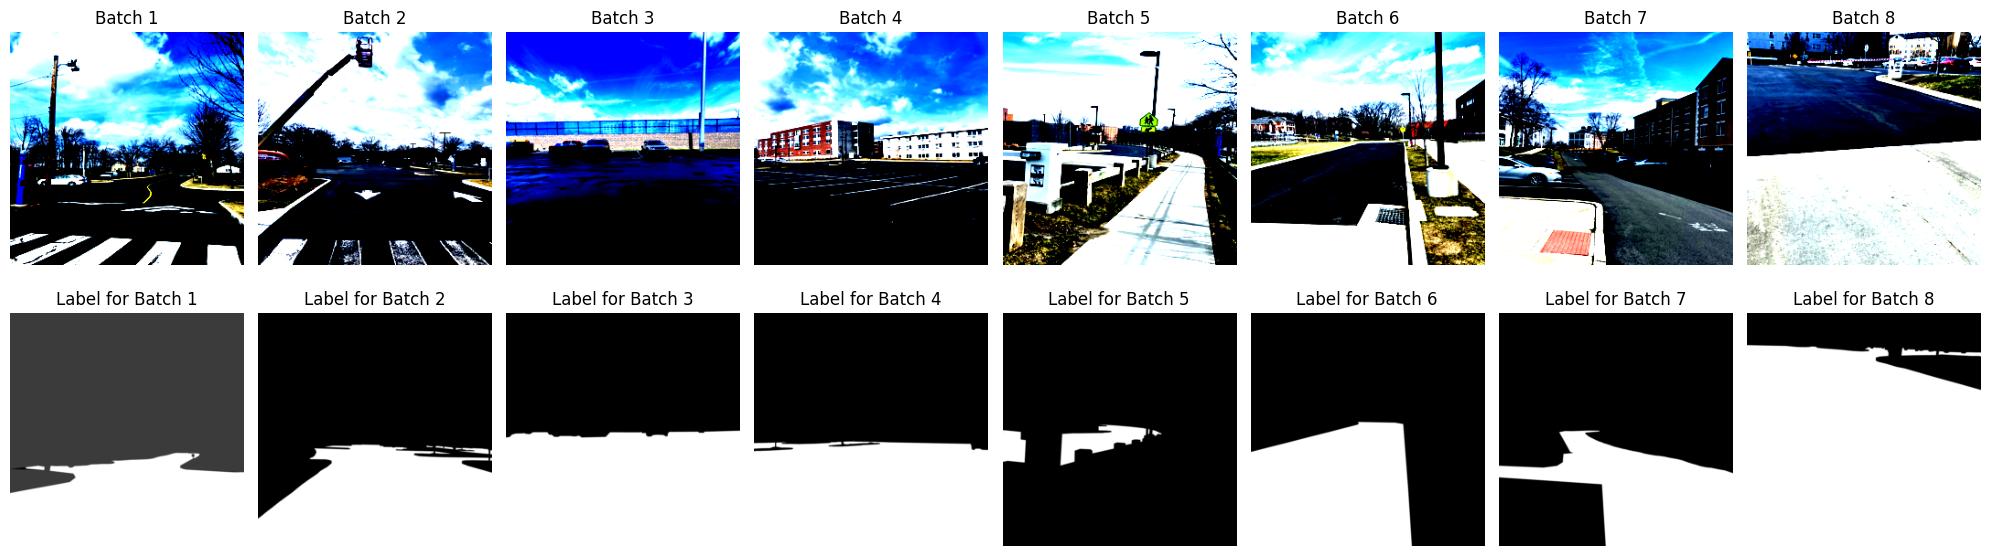

In [49]:
# Visualize first examples in first 8 batches

# Get the first 8 batches
num_batches_to_plot = 8
batch_counter = 0

# Lists to store sample images and labels for each batch
sample_images = []
label_images = []

for sample in train_loader:
    # Append the first image and label from the batch to the lists
    sample_images.append(sample['image'][0])  # Assuming batch_size > 0
    label_images.append(sample['label'][0])    # Assuming batch_size > 0

    batch_counter += 1
    if batch_counter >= num_batches_to_plot:
        break

# Create a 2x8 grid for plotting
fig, axes = plt.subplots(2, num_batches_to_plot, figsize=(20, 6))

for i in range(num_batches_to_plot):
    # Plot sample image
    sample_img = np.transpose(sample_images[i].numpy(), (1, 2, 0))  # Convert image tensor to numpy array and transpose
    axes[0, i].imshow(sample_img)
    axes[0, i].set_title(f'Batch {i+1}')
    axes[0, i].axis('off')

    # Plot label image
    label_img = np.transpose(label_images[i].numpy(), (1, 2, 0))  # Convert label tensor to numpy array and transpose
    axes[1, i].imshow(label_img, cmap='gray')
    axes[1, i].set_title(f'Label for Batch {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


### Build & Train Model

In [8]:
# implement network Encoder - Decoder Archetecture
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
    
        self.vgg = models.vgg16(pretrained=True).features # selects only conv net
        
        for name, m in self.vgg.named_parameters():  # freeze parameters of pre-trained VGG16 model
            m.requires_grad = False

    def forward(self, x):
        # Get the needed layers' outputs for building FCN-VGG16
        layers = {'16' : 'MaxPool2d_3_out',
                  '23' : 'MaxPool2d_4_out',
                  '30' : 'MaxPool2d_7_out'}

        features = {}

        for index in self.vgg._modules:
            layer = self.vgg._modules[index]
            x = layer(x) # forward pass through model

            # store layer feature activation/map for desired maxpool layers
            if str(index) in layers.keys():
                features[layers[str(index)]] = x


        return features['MaxPool2d_3_out'], features['MaxPool2d_4_out'], features['MaxPool2d_7_out']

In [10]:
class Decoder(nn.Module):
    def __init__(self, num_classes=1):
        super(Decoder, self).__init__()

        ## Decoder parameters
        self.vgg_layer3_depth = 256
        self.vgg_layer4_depth = 512
        self.vgg_layer7_depth = 512
        self.num_classes = num_classes
        self.height = 256
        self.width = 256

         ## Decoder layers definition

        # BUILD the 1x1 CONV SAMPLING AND SKIP CONNECTIONS - Maintain H and W, BRING VOLUME DEPTH IN SYNC WITH DECODER

        self.skip_vgg_layer4 = nn.Conv2d(in_channels = self.vgg_layer4_depth, out_channels = 256,
                                         kernel_size = (1,1), stride = 1, padding = 0)

        self.skip_vgg_layer3 = nn.Conv2d(in_channels = self.vgg_layer3_depth, out_channels = 128,
                                         kernel_size = (1,1), stride = 1, padding = 0)

        # BatchNorm Layers
        #self.dropout = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(16)

        # Deconv Layers
        self.deconv1 = nn.ConvTranspose2d(in_channels= 512, out_channels= 256,
                                                   kernel_size=2, stride=2, padding=0, dilation=1, output_padding=0)

        self.deconv2 = nn.ConvTranspose2d(in_channels= 256, out_channels= 128,
                                                   kernel_size=2, stride=2, padding=0, dilation=1, output_padding=0)

        self.deconv3 = nn.ConvTranspose2d(in_channels= 128, out_channels= 64,
                                                   kernel_size=2, stride=2, padding=0, dilation=1, output_padding=0)

        self.deconv4 = nn.ConvTranspose2d(in_channels= 64, out_channels= 32,
                                                   kernel_size=2, stride=2, padding=0, dilation=1, output_padding=0)

        self.deconv5 = nn.ConvTranspose2d(in_channels= 32, out_channels= 16,
                                                   kernel_size=2, stride=2, padding=0, dilation=1, output_padding=0)

        self.AMP = nn.AdaptiveMaxPool3d(output_size = (self.num_classes, self.height, self.width))


        # Initialize decoder layers using Xavier's initialization
        self.model_init()


    def forward(self, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out):

        ## Decoder forward useful parameters
        self.batch_size = vgg_layer3_out.shape[0]
        self.vgg_layer3_out = vgg_layer3_out
        self.vgg_layer4_out = vgg_layer4_out
        self.vgg_layer7_out = vgg_layer7_out


        # PASS VGG OUTPUTS THRU 1x1 CONV LAYERS

        self.vgg_layer4_logits = self.skip_vgg_layer4(self.vgg_layer4_out)          # 128 x 14 x 14 (for 224x224)

        self.vgg_layer3_logits = self.skip_vgg_layer3(self.vgg_layer3_out)          # 64 x 28 x 28  (for 224x224)


        # FEED FORWARD DECODER

        # Upsampling H,W by 2
        x = F.relu_(self.deconv1( self.vgg_layer7_out))

        # Skip connection
        x = self.bn1(x.add(self.vgg_layer4_logits))

        # Upsampling H,W by 2
        x = F.relu_(self.deconv2(x))

        # Skip connection
        x = self.bn2(x.add(self.vgg_layer3_logits))

        # Upsampling H,W by 8
        x = self.bn3(F.relu_(self.deconv3(x)))


        # Upsampling H,W by 16
        x = self.bn4(F.relu_(self.deconv4(x)))

        # Upsampling H,W by 32
        x = self.bn5(F.relu_(self.deconv5(x)))

        # Bring feature depth to num_classes
        output = self.AMP(x)

        # We ensure appropriate Tensor shape:  batchsize x num_classes x H x W
        output = output.view(self.batch_size,self.num_classes, self.height, self.width)

        return output

    def model_init(self):
        # We initialize the decoder parameters using Xavier's approach
        torch.nn.init.xavier_uniform_(self.deconv1.weight)
        torch.nn.init.xavier_uniform_(self.deconv2.weight)
        torch.nn.init.xavier_uniform_(self.deconv3.weight)
        torch.nn.init.xavier_uniform_(self.deconv4.weight)
        torch.nn.init.xavier_uniform_(self.deconv5.weight)


In [54]:
###### Instantiate the models


Decoder(
  (skip_vgg_layer4): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  (skip_vgg_layer3): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
  (deconv2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (deconv4): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (deconv5): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (AMP): AdaptiveMaxPool3d(output

In [232]:
def count_parameters(model):
    return np.sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate the models
num_classes = 1
encoder = Encoder()
decoder = Decoder(num_classes)

# Move models to GPU if CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)


# Define the loss function.
criterion = nn.BCELoss().cuda() if torch.cuda.is_available() else nn.BCELoss()

# Specify the learnable parameters of the model.
params = list(decoder.parameters())

# Define the optimizer.
optimizer = optim.Adam(params, lr=0.001, betas=(0.9,0.999), eps=1e-08)

print(encoder)
print()
print(decoder)
print()
print('Total number of trainable parameters for encoder [%d] and decoder [%d]'
      %(count_parameters(encoder), count_parameters(decoder)))

Encoder(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [78]:
import time
# from workspace_utils import active_session

num_epochs = 15
total_steps = len(train_loader)
print_every = 10
save_every = 10

# Loss values at every epoch
train_losses = [] 
val_losses = []

# with active_session():

start_time = time.time()

for epoch in range(num_epochs):

    previous_time = time.time()
    
    encoder.train()
    decoder.train()
    
    for i, batch in enumerate(train_loader):

        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()

        
        # Obtain the batch.
        images, labels = batch['image'], batch['label']

        # Move batch of images and captions to GPU if CUDA is available.
        # images = images.to(device)
        # labels = labels.to(device)  # batch_size x H x W  (road = 1, background = 255 ignored by loss function => 0)


        # Pass the inputs through the FCN model.
        vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(images)
        outputs = decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out) # batch_size x num_classes x H x W
        outputs = torch.sigmoid(outputs) # to get scores

        # Calculate the batch loss.
        train_loss = criterion(outputs, labels.float())
        

        # Backward pass.
        train_loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        # Get and display train statistics.
        current_time = time.time()
        stats = ('Train Info: Epoch [%d/%d], Step [%d/%d],\t Loss: %.4f,\t training time: %d sec\t' % 
                 (epoch,
                  num_epochs,
                  i+1,
                  total_steps,
                  train_loss.item(),
                  (current_time - previous_time))
                )
                 
        
        # Print new stat on same line
        print('\r' + stats, end="")
                 
    # store loss            
    train_losses.append(train_loss.item())
    train_time_total = time.time() - previous_time # for general info
                 
    # validate
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        
        for i, batch in enumerate(val_loader):
            # unpack batch to get data and associate labels
            images, labels = batch['image'], batch['label']

            # forward propagte
            vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(images)
            outputs = decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out)
            outputs = torch.sigmoid(outputs)
            
            # calculating loss
            val_loss = criterion(outputs, labels.float())
            

    
    current_time = time.time()
    stats = ('General Info: Epoch [%d/%d],\t Train Loss: %.4f,\t Val Loss: %.4f,\t training time: %d sec,\t execution time elapsed:\t %d hr %d min' % 
             (epoch,
              num_epochs,
              train_loss.item(),
              val_loss.item(),
              train_time_total,
              (current_time-start_time)//3600,
              (current_time-start_time)//60-((current_time-start_time)//3600)*60))

    # Print training statistics (on different line).
    print('\r' + stats)
    
    val_losses.append(val_loss.item())
        

    # Save the weights.
    if val_loss < train_loss:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-AMP-%d.pth' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-AMP-%d.pth' % epoch))

General Info: Epoch [0/40],	 Train Loss: 1.0365,	 Val Loss: 0.9749,	 training time: 174 sec,	 execution time elapsed:	 0 hr 3 min
General Info: Epoch [1/40],	 Train Loss: 0.6386,	 Val Loss: 0.6544,	 training time: 170 sec,	 execution time elapsed:	 0 hr 6 min
General Info: Epoch [2/40],	 Train Loss: 0.5925,	 Val Loss: 0.6085,	 training time: 168 sec,	 execution time elapsed:	 0 hr 9 min
General Info: Epoch [3/40],	 Train Loss: 0.6149,	 Val Loss: 0.5756,	 training time: 169 sec,	 execution time elapsed:	 0 hr 12 min
General Info: Epoch [4/40],	 Train Loss: 0.5361,	 Val Loss: 0.5518,	 training time: 166 sec,	 execution time elapsed:	 0 hr 15 min
General Info: Epoch [5/40],	 Train Loss: 0.4967,	 Val Loss: 0.5413,	 training time: 169 sec,	 execution time elapsed:	 0 hr 19 min
General Info: Epoch [6/40],	 Train Loss: 0.5488,	 Val Loss: 0.5356,	 training time: 167 sec,	 execution time elapsed:	 0 hr 22 min
General Info: Epoch [7/40],	 Train Loss: 0.4982,	 Val Loss: 0.5342,	 training time: 16

KeyboardInterrupt: 

In [106]:
# visualize evaluation results 

plt.figure(figsize=(12, 6))
plt.plot(train_losses_values)
plt.plot(val_losses)
plt.xticks(np.arange(0, 18, step=1))
plt.title('Train vs Validation Loss of FCN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Val Loss']);

In [111]:
# Calculate Test Loss and visualize test Predictions
with torch.no_grad():
    encoder.eval()
    decoder.eval()
    test_loss = 0
    num_batches = 0
    
    for i, batch in enumerate(test_loader):
    
        
        for i, batch in enumerate(val_loader):
            # unpack batch to get data and associate labels
            images, labels = batch['image'], batch['label']
    
            # forward propagte
            vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(images)
            outputs = decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out)
            outputs = torch.sigmoid(outputs)
            
            # calculating loss
            test_loss = criterion(outputs, labels.float())

            # aggregate loss
            test_loss += test_loss.item()
            num_batches += 1

avg_test_loss = test_loss / num_batches
print(f'Average Test Loss: {avg_test_loss}')




Average Test Loss: 0.11342753469944


### Load Best Model and visualize Predicitions

In [15]:
num_classes = 1
encoder = Encoder()
decoder = Decoder(num_classes)

encoder_state_dict = torch.load('./Models/encoder-AMP-12.pth')
decoder_state_dict = torch.load('./Models/decoder-AMP-12.pth')

encoder.load_state_dict(encoder_state_dict)
encoder.eval() # mode for inference
decoder.load_state_dict(decoder_state_dict)
decoder.eval()
print(encoder)
print(decoder)

Decoder(
  (skip_vgg_layer4): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  (skip_vgg_layer3): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
  (deconv2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (deconv4): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (deconv5): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (AMP): AdaptiveMaxPool3d(output

In [35]:
# select one image from test batch 1
batch = next(iter(test_loader))
test_imgs, test_lbls, test_img_paths = (batch['image'][0:2], # select only one test image
                                     batch['label'][0:2],
                                     batch['file_names']['image'][0:2]
                                    )

encoder.eval()
decoder.eval()

# make prediction on image
with torch.no_grad():
    vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(test_imgs)
    predictions = decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out)
    predictions = torch.sigmoid(predictions)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


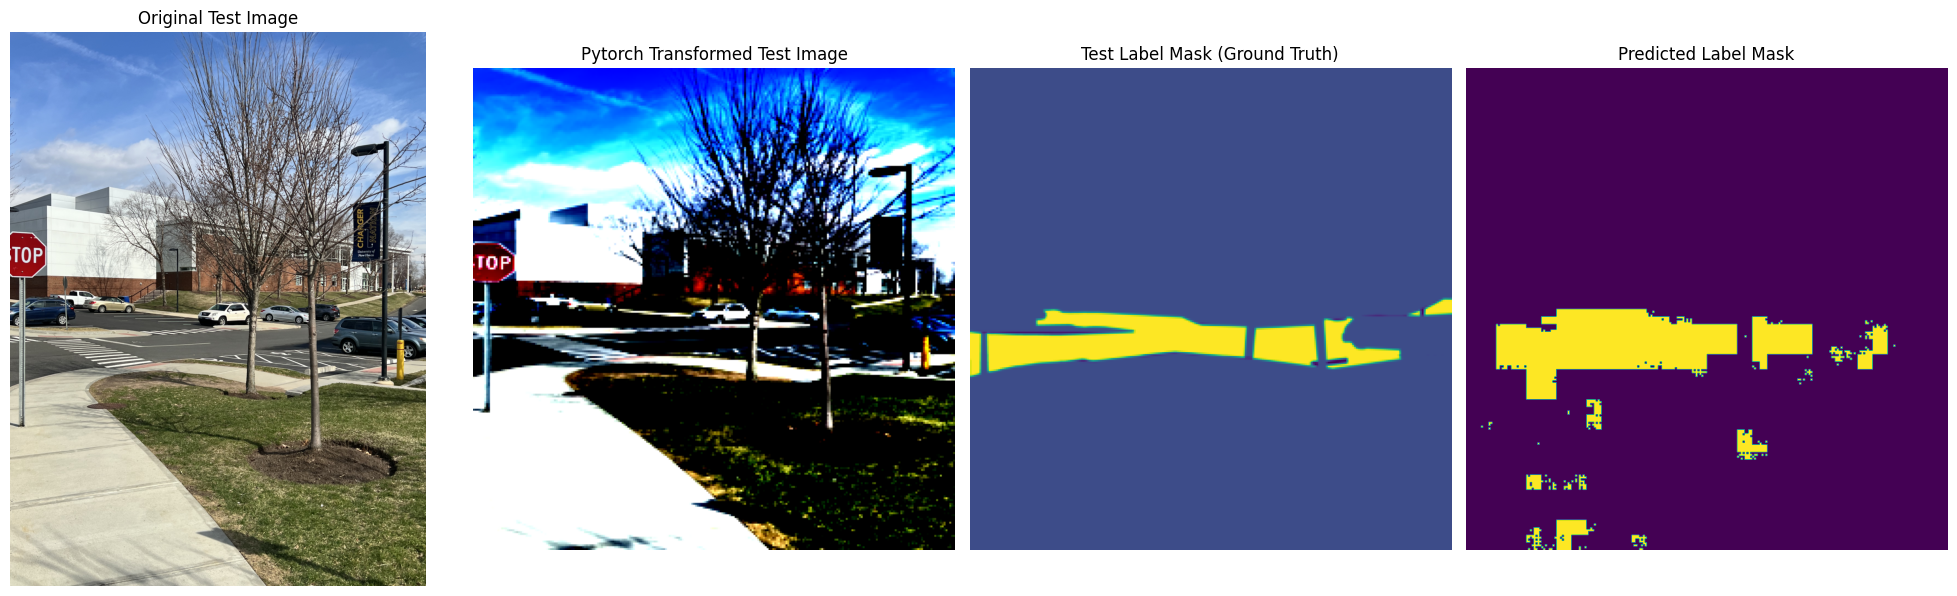

In [37]:
# visualize original test image, transformed test image, test label and predicted label (segmentation mask)

# Define the 4 images
initial_image = dataset._rotate(Image.open(test_img_paths[0])) # rotate function to keep orientation
image = np.transpose(test_imgs[0].numpy(), (1, 2, 0)) # h x w x ch
label = np.transpose(test_lbls[0].numpy(), (1, 2, 0)) # h x w x ch
pred_label = (np.transpose(predictions[0].detach().numpy(), (1, 2, 0))>0.5).astype('float')

# plot images
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
axes[0].imshow(initial_image)
axes[0].set_title('Original Test Image')
axes[0].axis('off')

axes[1].imshow(image)
axes[1].set_title('Pytorch Transformed Test Image')
axes[1].axis('off')

axes[2].imshow(label)
axes[2].set_title('Test Label Mask (Ground Truth)')
axes[2].axis('off')

axes[3].imshow(pred_label)
axes[3].set_title('Predicted Label Mask')
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [38]:
# visualize original test image, transformed test image, test label and predicted label (segmentation mask)

# Define the 4 images
initial_image = dataset._rotate(Image.open(test_img_paths[1])) # rotate function to keep orientation
image = np.transpose(test_imgs[1].numpy(), (1, 2, 0)) # h x w x ch
label = np.transpose(test_lbls[1].numpy(), (1, 2, 0)) # h x w x ch
pred_label = (np.transpose(predictions[1].detach().numpy(), (1, 2, 0))>0.5).astype('float')

# plot images
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
axes[0].imshow(initial_image)
axes[0].set_title('Original Test Image')
axes[0].axis('off')

axes[1].imshow(image)
axes[1].set_title('Pytorch Transformed Test Image')
axes[1].axis('off')

axes[2].imshow(label)
axes[2].set_title('Test Label Mask (Ground Truth)')
axes[2].axis('off')

axes[3].imshow(pred_label)
axes[3].set_title('Predicted Label Mask')
axes[3].axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


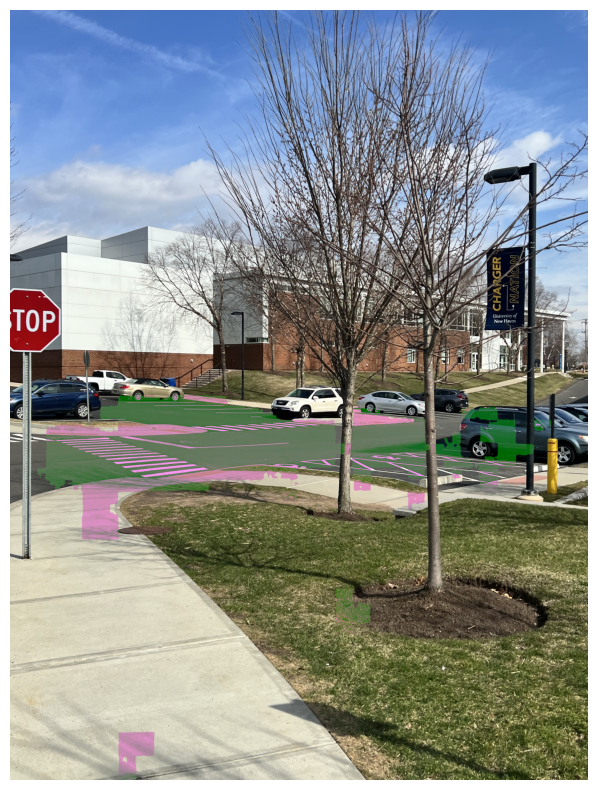

In [205]:
# Overlay one original test image with predicted mask

# define original image
initial_image = dataset._rotate(Image.open(test_img_path))

# resize prediction, upscale pixel values
pred_label = (cv2.resize(np.transpose(prediction[0].detach().numpy(), (1, 2, 0)), (3024, 4032))>0.5).astype('float')
pred_label[pred_label==1.0] = 127.0

# Make prediction label have 3 channels
pred_label = cv2.merge([np.zeros_like(pred_label), 
                                     pred_label,
                                     np.zeros_like(pred_label)]) # out shape (4032, 3024, 3)


# Merge original image with mask

# Create a copy of the original image
overlay_image = np.copy(initial_image)

# Define transparency (alpha) value for the overlay
alpha = 0.9  # Adjust as needed for the desired transparency level

# Apply the segmentation mask on the overlay image
overlay_image[pred_label != 0] = (overlay_image[pred_label != 0] * (1 - alpha) +
                                          pred_label[pred_label != 0] * alpha).astype(np.uint8)

# Display the original image and the overlay
plt.figure(figsize=(15, 10))
plt.imshow(initial_image)
plt.imshow(overlay_image, alpha=alpha)  # Set alpha value to make the overlay faint
plt.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


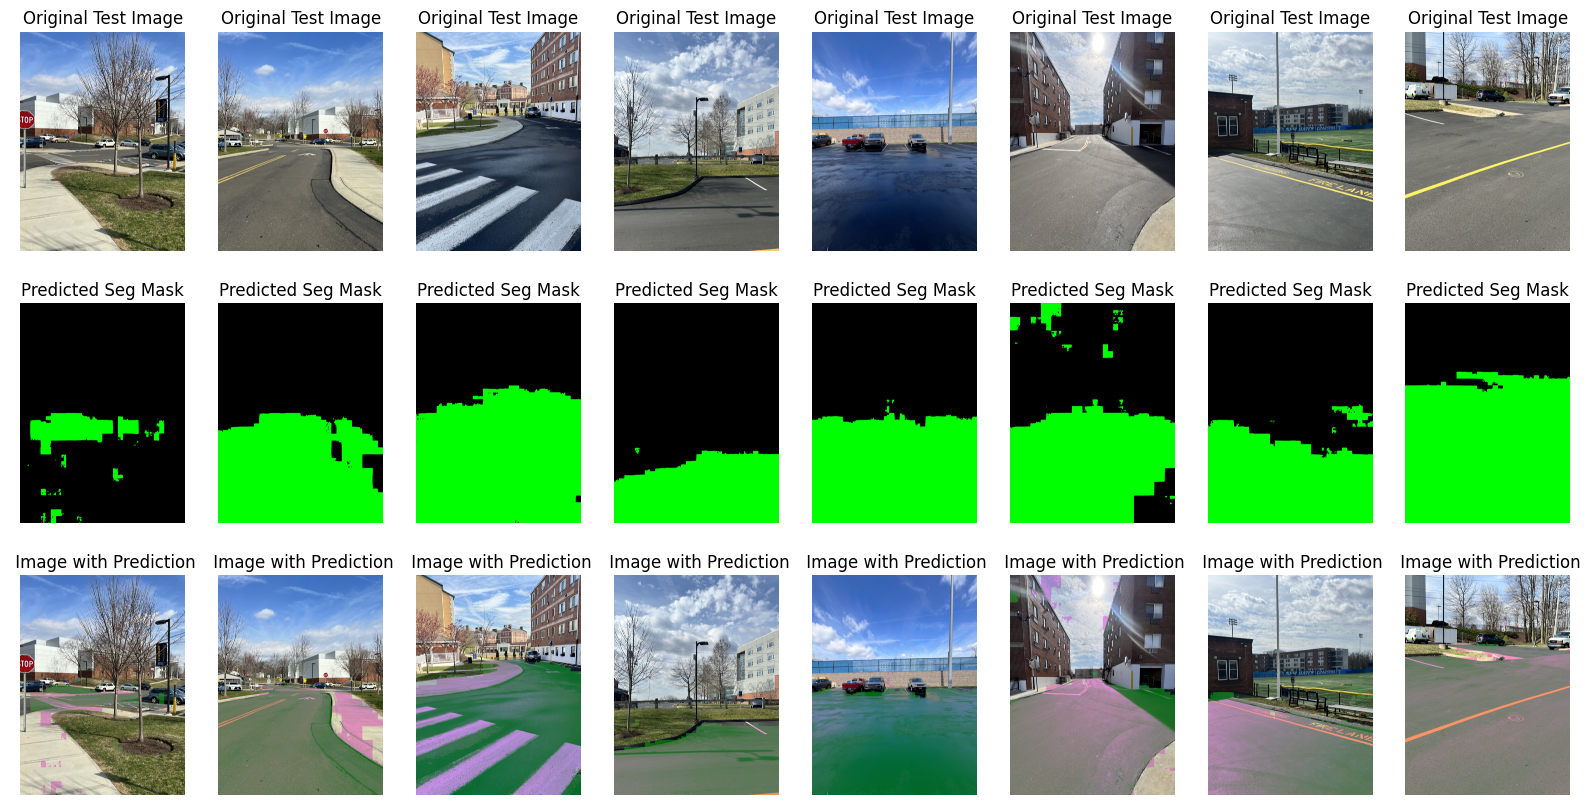

In [39]:
# Overlay predicted mask on original image for one test batch

# get batch
batch = next(iter(test_loader))

# unpack batch
test_imgs, test_lbls, test_img_paths = (batch['image'], 
                                     batch['label'],
                                     batch['file_names']['image']
                                    )
# Create subplot for image
fig, axes = plt.subplots(3, 8, figsize=(20, 10))

encoder.eval()
decoder.eval()

# make prediction on image display results
with torch.no_grad():
    
    # Get prediction for image
    vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(test_imgs)
    predictions = decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out)
    predictions = torch.sigmoid(predictions)
    
    
    # Loop through each test image in batch and display overlay of predicted segmentation mask on original image
    for ix in range(0, 8):
        # get original image array
        initial_image = dataset._rotate(Image.open(test_img_paths[ix]))
        
        # get and resize pred label (segmentation mask)
        pred_label = (cv2.resize(np.transpose(predictions[ix].detach().numpy(), (1, 2, 0)), (3024, 4032))>0.5).astype('float')
        pred_label[pred_label==1.0] = 127.0

        # Transform pred label array and merge overlay image (segmentation mask) and original image

        # convert pred label array from 1D to 3D
        pred_label = cv2.merge([np.zeros_like(pred_label), 
                                             pred_label,
                                             np.zeros_like(pred_label)]) # out shape (4032, 3024, 3)
        
        # Create a copy of the original image
        overlay_image = np.copy(initial_image)
        
        # Define transparency (alpha) value for the overlay
        alpha = 0.9  # Adjust as needed for the desired transparency level
        
        # Apply the segmentation mask on the overlay image
        overlay_image[pred_label != 0] = (overlay_image[pred_label != 0] * (1 - alpha) +
                                                  pred_label[pred_label != 0] * alpha).astype(np.uint8)
            
        # Plot the images
        axes[0, ix].imshow(initial_image)
        axes[0, ix].set_title('Original Test Image')
        axes[0, ix].axis('off')

        axes[1, ix].imshow(pred_label)
        axes[1, ix].set_title('Predicted Seg Mask')
        axes[1, ix].axis('off')

        axes[2, ix].imshow(initial_image)
        axes[2, ix].imshow(overlay_image, alpha=alpha)
        axes[2, ix].set_title(' Image with Prediction')
        axes[2, ix].axis('off')